In [3]:
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.vision import *
from pathlib import Path

from utils import *
from dark import *
from wrn4 import *

# from torch.utils.data.sampler import WeightedRandomSampler
from imba_sampler import ImbalancedDatasetSampler

torch.backends.cudnn.benchmark = False

In [26]:
MASKS = 'train.csv'

PATH = Path('./')
TEST = Path('test512/')
TRAIN_AUG = Path('../aug/train/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)

sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

classes = [str(l) for l in range(28)]

In [27]:
df = pd.read_csv('aug_train.csv'); len(df)

99165

In [28]:
arch = models.resnet50

In [29]:
stats = ([0.08069, 0.05258, 0.05487], [0.13704,0.10145, 0.15313])
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_lighting=0.1, max_warp=0.4)

In [39]:
def get_data(sz=64, bs=64, pct=0.2, sample=5000):
#     sz, pct, bs = 64, 0.2, 64
    src = (ImageItemList.from_df(df=df, path=PATH, folder=TRAIN_AUG, suffix='.png')
           .random_split_by_pct(pct)
           .label_from_df(sep=' ', classes=classes)
           .add_test([TEST/(f+'.png') for f in test_names]))
    data = (src.transform(tfms, size=sz))
    #         .databunch(bs=bs).normalize(stats))

    test_ds = data.test
    train_ds, val_ds = data.train, data.valid
    datasets = [train_ds,val_ds, test_ds]
    sampler = ImbalancedDatasetSampler(datasets[0], num_samples=sample)
    train_dl = DataLoader(datasets[0], bs, sampler=sampler, num_workers=12)
    val_dl = DataLoader(datasets[1], 2*bs, False, num_workers=8)
    test_dl = DataLoader(datasets[2], 2*bs, False, num_workers=8)

    return ImageDataBunch(train_dl, val_dl, test_dl).normalize(stats)

In [40]:
def get_learner(data, focal=False, fp16=False):
    learn = create_cnn(data, arch, metrics=[accuracy_thresh, f1], 
               callback_fns=[partial(GradientClipping, clip=0.1), ShowGraph])
    if focal: learn.loss_func = FocalLoss()
    if fp16: learn.to_fp16();
#     learn.split((arch.layers[9],arch.layers[13]))  #Split for 444 model [11,20]
    return learn.mixup(stack_y=False)

# 256

In [57]:
data = get_data(256, 128, 0.1, sample=None)

In [58]:
learn = get_learner(data, focal=True, fp16=True)

In [59]:
learn.model = nn.DataParallel(learn.model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


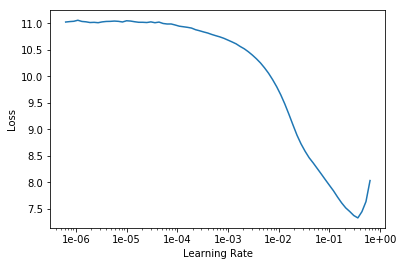

In [60]:
learn.lr_find()
learn.recorder.plot()

In [61]:
lr = 1e-2

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,1.135363,0.912803,0.960266,0.192009
2,0.947917,0.766521,0.965121,0.293362
3,0.892803,0.760909,0.967149,0.348926
4,0.832565,1.026014,0.968067,0.396405
5,0.791180,0.992103,0.968885,0.398612
6,0.767381,0.737421,0.969382,0.404925


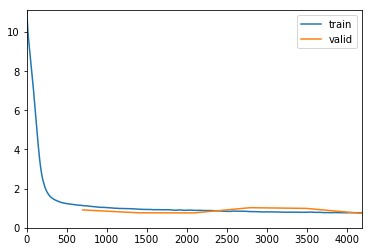

CPU times: user 14min 51s, sys: 6min 50s, total: 21min 42s
Wall time: 21min 39s


In [62]:
%time learn.fit_one_cycle(6, slice(lr))

In [63]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,0.882792,0.861380,0.961224,0.280923
2,0.835424,0.807899,0.963155,0.363420
3,0.750759,0.815948,0.965413,0.369932
4,0.673565,0.595489,0.972757,0.464924
5,0.616353,0.537111,0.974900,0.514510
6,0.588206,0.517057,0.975807,0.524709


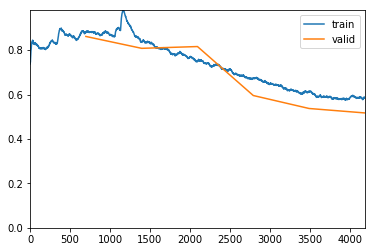

CPU times: user 17min 21s, sys: 8min 38s, total: 26min
Wall time: 25min 40s


In [64]:
%time learn.fit_one_cycle(6, slice(lr/10, lr/3))

In [65]:
learn.save('r50_256');

# 512

In [74]:
learn.data = get_data(512, 48, 0.01, sample=None)

In [ ]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,0.730310,0.648036,0.969475,0.379759


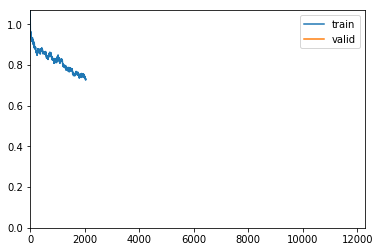

In [ ]:
%time learn.fit_one_cycle(6, slice(lr/3))

In [69]:
learn.save('r50_512')

In [70]:
learn.unfreeze()

In [71]:
lr = 1e-2
%time learn.fit_one_cycle(10, slice(lr/10, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,f1


RuntimeError: CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 7.77 GiB total capacity; 6.63 GiB already allocated; 135.56 MiB free; 120.28 MiB cached)

In [72]:
learn.save('r50_512_u')

In [73]:
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

AttributeError: 'NoneType' object has no attribute 'add_tfm'

# Sub File

In [ ]:
model_name = 'r50'

In [ ]:
preds = to_np(p.sigmoid())  #Check if we are using focal loss or BCE.
threshold = 0.4 #ths
print(preds.shape)
classes = np.array(data.classes)
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

In [ ]:
preds = to_np(p.sigmoid())  #Check if we are using focal loss or BCE.
np.save(model_name, preds)

In [ ]:
frame = pd.DataFrame(np.array([test_names, res]).T, columns = ['Id','Predicted'])
frame.to_csv(f'{model_name}.csv', index=False)

In [ ]:
frame.head()

In [ ]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f "r50.csv" -m "R50"